In [ ]:
import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

In [ ]:
from src.data.imagenet_no_transforms import *

train_loader, val_loader, test_loader = get_tinyimagenet200_hf_dataloaders(
    batch_size=64, data_dir="./data",
    num_workers=2,
    val_split=0.1, seed=77)

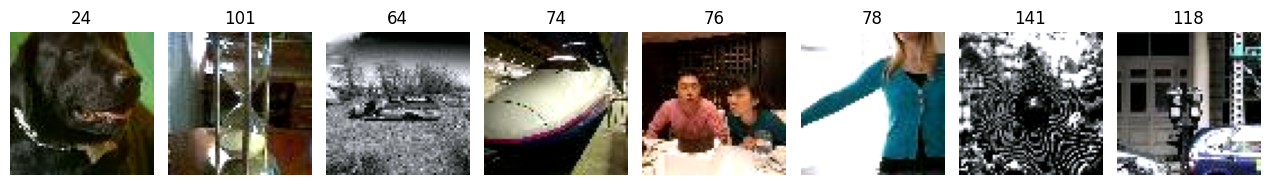

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_batch(images, labels, n=8):
    mean = torch.tensor((0.5071, 0.4867, 0.4408)).view(1,3,1,1)
    std  = torch.tensor((0.2675, 0.2565, 0.2761)).view(1,3,1,1)

    imgs = images[:n].cpu() * std + mean
    imgs = imgs.clamp(0, 1)

    fig, axes = plt.subplots(1, n, figsize=(1.6*n, 2))
    for i in range(n):
        axes[i].imshow(imgs[i].permute(1,2,0))
        axes[i].set_title(str(labels[i].item()))
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

---

In [ ]:
import timm
import torch.nn as nn

device = 'cuda'

model_vit3 = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=False,
    num_classes=200,
    img_size=64,
    window_size=4
).to(device)

current_dim = model_vit3.patch_embed.proj.out_channels

model_vit3.patch_embed.proj = nn.Conv2d(
    in_channels=3,
    out_channels=current_dim,
    kernel_size=2,
    stride=2)

model_vit3.patch_embed.patch_size = (2, 2)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model_vit3)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 27,651,218


In [ ]:
import random, numpy as np
import torch.nn.functional as F
from src.training.train_full_model import *

seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history, model = train_model(
    model=model_vit3,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_swin.pt",
    last_path="last_swin.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=200,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1406 | total_steps=35150 | warmup_steps=1757
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=200
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1406] loss 5.1613 | top1 1.77% | top3 4.61% | top5 7.40% | 1083.4 img/s | lr 1.14e-04 | gnorm 3.649 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1406] loss 5.0605 | top1 2.51% | top3 6.34% | top5 9.76% | 1142.3 img/s | lr 2.28e-04 | gnorm 3.302 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1200/1406] loss 4.9775 | top1 3.26% | top3 7.92% | top5 11.89% | 1164.4 img/s | lr 3.41e-04 | gnorm 3.115 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1406/1406] loss 4.9307 | top1 3.70% | top3 8.83% | top5 13.08% | 1170.2 img/s | lr 4.00e-04 | gnorm 3.061 | cl

In [ ]:
evaluate_one_epoch(model=model_vit3, dataloader=test_loader, device=device)

(2.8172476770401, {'top1': 34.81, 'top3': 53.67, 'top5': 61.78})

In [ ]:
import pickle

with open("SwinViT_TinyImagnet200.pkl", "wb") as f:
    pickle.dump(history, f)

---

## Food 101 

In [ ]:
from src.data.load_food101 import *

train_loader, val_loader, test_loader = get_food101_hf_dataloaders(
     batch_size=64, num_workers=2, img_size=64, seed=7)

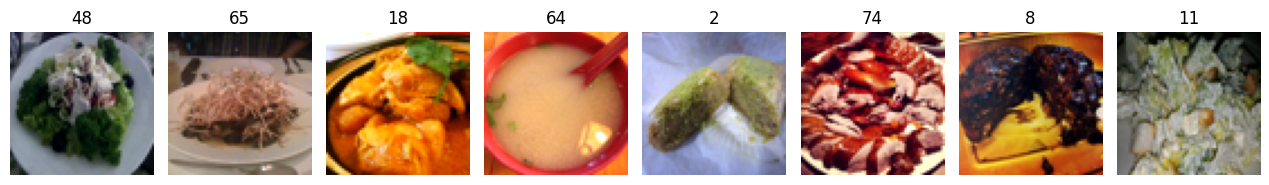

In [8]:
import matplotlib.pyplot as plt

def show_batch(images, labels, n=8):
    mean = torch.tensor((0.5071, 0.4867, 0.4408)).view(1,3,1,1)
    std  = torch.tensor((0.2675, 0.2565, 0.2761)).view(1,3,1,1)

    imgs = images[:n].cpu() * std + mean
    imgs = imgs.clamp(0, 1)

    fig, axes = plt.subplots(1, n, figsize=(1.6*n, 2))
    for i in range(n):
        axes[i].imshow(imgs[i].permute(1,2,0))
        axes[i].set_title(str(labels[i].item()))
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

In [9]:
import timm
from timm.layers import trunc_normal_
import torch.nn.functional as F

device = 'cuda'

model_vit3 = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=False,
    num_classes=101,
    img_size=64,
    window_size=8
).to(device)

current_dim = model_vit3.patch_embed.proj.out_channels

model_vit3.patch_embed.proj = nn.Conv2d(
    in_channels=3,
    out_channels=current_dim,
    kernel_size=2,
    stride=2)
model_vit3.patch_embed.patch_size = (2, 2)

trunc_normal_(model_vit3.patch_embed.proj.weight, std=0.02)

if model_vit3.patch_embed.proj.bias is not None:
    nn.init.constant_(model_vit3.patch_embed.proj.bias, 0)

model_vit3 = model_vit3.to(device)


def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model_vit3)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 27,578,255


In [ ]:
import random, numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="PIL.TiffImagePlugin")


seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model = train_model(
    model=model_vit3,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_Swin.pt",
    last_path="last_Swin.pt",
    resume_path=None,

    # Augmentationsas
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=101,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1183 | total_steps=29575 | warmup_steps=1478
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=101
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1183] loss 4.5843 | top1 2.48% | top3 6.45% | top5 9.74% | 458.9 img/s | lr 1.35e-04 | gnorm 3.294 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1183] loss 4.4921 | top1 3.35% | top3 8.53% | top5 12.73% | 473.4 img/s | lr 2.71e-04 | gnorm inf | clip 100.0% | oflow 1 | nonfinite 0 | scale 32768.0
[train step 1183/1183] loss 4.4338 | top1 3.83% | top3 9.78% | top5 14.53% | 477.0 img/s | lr 4.00e-04 | gnorm inf | clip 100.0% | oflow 1 | nonfinite 0 | scale 32768.0
[Train] loss 4.4338 | top1 3.83% | top3 9.78% | top5 14.53% | lr 4.00e-04 | grad_norm inf | clip 100.0% | amp_overflows 1 | nonf

In [11]:
import pickle

with open("Swin_Food101.pkl", "wb") as f:
    pickle.dump(history1, f)

---

## Oxfordpets 37

In [ ]:
from src.data.load_oxfordpets import *

train_loader, val_loader, test_loader = get_oxford_pets37_dataloaders(
     batch_size=64, img_size=64, val_split=0.1, num_workers=4, seed=7)

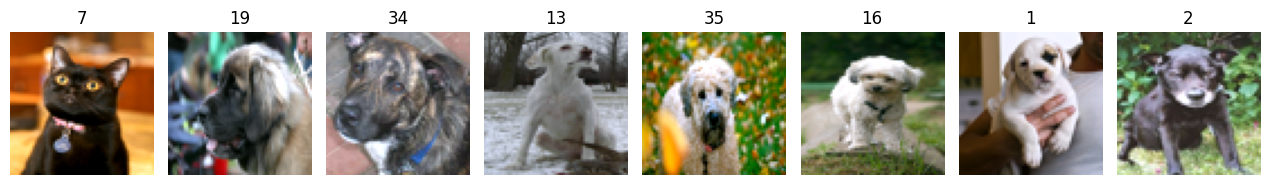

In [ ]:
images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

In [ ]:
from timm.layers import trunc_normal_

model_vit3 = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=False,
    num_classes=37,
    img_size=64,
    window_size=8).to(device)

current_dim = model_vit3.patch_embed.proj.out_channels

model_vit3.patch_embed.proj = nn.Conv2d(
    in_channels=3,
    out_channels=current_dim,
    kernel_size=2,
    stride=2)
model_vit3.patch_embed.patch_size = (2, 2)

trunc_normal_(model_vit3.patch_embed.proj.weight, std=0.02)

if model_vit3.patch_embed.proj.bias is not None:
    nn.init.constant_(model_vit3.patch_embed.proj.bias, 0)

model_vit3 = model_vit3.to(device)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model_vit3)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 27,529,039


In [ ]:
seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model_vit3 = train_model(
    model=model_vit3,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_Swin.pt",
    last_path="last_Swin.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=37, early_stop_patience=25,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=51 | total_steps=1275 | warmup_steps=63
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=37
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 51/51] loss 3.7459 | top1 3.40% | top3 9.93% | top5 15.90% | 728.3 img/s | lr 4.05e-04 | gnorm inf | clip 100.0% | oflow 1 | nonfinite 0 | scale 32768.0
[Train] loss 3.7459 | top1 3.40% | top3 9.93% | top5 15.90% | lr 4.05e-04 | grad_norm inf | clip 100.0% | amp_overflows 1 | nonfinite_loss 0 | scale 32768.0
[Train] mem_peak alloc 3.04 GiB | reserved 3.33 GiB
[Val]   loss 3.7175 | top1 3.80% | top3 8.42% | top5 14.40%
[Val]   mem_peak alloc 1.98 GiB | reserved 3.33 GiB
Best saved to best_Swin.pt (val top1 3.80%)
Epoch time: 0.11 min

=== Epoch 2/25 ===
[train step 51/51] loss 3.6381 | top1 3.77% | top3 10.66% | top5 17.1

In [ ]:
evaluate_one_epoch(model=model_vit3, dataloader=test_loader, device=device)

(3.5211516350028496,
 {'top1': 6.077950395203053,
  'top3': 15.917143635868085,
  'top5': 24.039247751430906})

In [ ]:
import pickle

with open("Swin_OxfordPets37.pkl", "wb") as f:
    pickle.dump(history1, f)

---

## SVHN

In [ ]:
from src.data.load_svhn import *

train_loader, val_loader, test_loader = get_svhn_dataloaders(
     batch_size=64, img_size=32, val_split=0.1, num_workers=4)

In [ ]:
images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

In [ ]:
from timm.layers import trunc_normal_

model_vit3 = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=False,
    num_classes=10,
    img_size=32,
    window_size=2).to(device)

current_dim = model_vit3.patch_embed.proj.out_channels
model_vit3.patch_embed.proj = nn.Conv2d(
    in_channels=3,
    out_channels=current_dim,
    kernel_size=2,
    stride=2)
model_vit3.patch_embed.patch_size = (2, 2)


trunc_normal_(model_vit3.patch_embed.proj.weight, std=0.02)
if model_vit3.patch_embed.proj.bias is not None:
    nn.init.constant_(model_vit3.patch_embed.proj.bias, 0)

model_vit3 = model_vit3.to(device)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model_vit3)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 27,501,124


In [ ]:
seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model_vit3 = train_model(
    model=model_vit3,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_outgrid32.pt",
    last_path="last_outgrid32.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=10,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1031 | total_steps=25775 | warmup_steps=1288
batch_size=64 | input_shape=(64, 3, 32, 32) | num_classes=10
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1031] loss 2.3272 | top1 18.98% | top3 44.00% | top5 62.58% | 1178.9 img/s | lr 1.55e-04 | gnorm inf | clip 100.0% | oflow 1 | nonfinite 0 | scale 32768.0
[train step 800/1031] loss 1.9958 | top1 33.05% | top3 58.82% | top5 74.17% | 1164.6 img/s | lr 3.11e-04 | gnorm inf | clip 100.0% | oflow 2 | nonfinite 0 | scale 16384.0
[train step 1031/1031] loss 1.8603 | top1 38.82% | top3 63.69% | top5 77.63% | 1168.8 img/s | lr 4.00e-04 | gnorm inf | clip 100.0% | oflow 2 | nonfinite 0 | scale 16384.0
[Train] loss 1.8603 | top1 38.82% | top3 63.69% | top5 77.63% | lr 4.00e-04 | grad_norm inf | clip 100.0% | amp_overflows

In [ ]:
evaluate_one_epoch(model=model_vit3, dataloader=test_loader, device=device)

(0.3138550418190379,
 {'top1': 91.20313460356485,
  'top3': 97.06515058389674,
  'top5': 98.62861094038107})

In [ ]:
with open("Swin_SVHNL.pkl", "wb") as f:
    pickle.dump(history1, f)